In [1]:
import pandas as pd
import numpy as np
import re
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix
import xgboost as xgb

## 1- IMPORT DATA

In [2]:
#On recupère le dataframe mergé
df = pd.read_feather("kernel Kaggle préparation données/data_feather")

## 2- TRAIN TEST SPLIT

In [3]:
# On recupère les données avec une target et les données sans
train = df[df["TARGET"].notnull()]
test = df[df["TARGET"].isnull()]

X_train = train.drop(["TARGET", "SK_ID_CURR"], axis = 1)
X_test = test.drop(["TARGET", "SK_ID_CURR"], axis = 1)
y_train = train["TARGET"]

del df

In [4]:
#On recupère le nombre de valeurs nulles
X_train_na = X_train.isna().sum()

#On recupère les variables avec plus de 60% de valeur nulles
X_train_na_60 = list(X_train_na[(X_train_na*100/X_train.shape[0]) > 60].index)

#On supprime les variables ayant plus de 60% de valeurs nulles
X_train.drop(columns=X_train_na_60, inplace=True)

In [5]:
%%time

#On remplace les valeurs nan restantes par 0
X_train.replace({np.nan : 0}, inplace= True)

Wall time: 2.21 s


In [6]:
%%time

#On remplace les valeurs inf par la valeur max et les valeurs -inf par la valeur min
for c in X_train.columns:
    if X_train[c].isin([-np.inf, np.inf]).any():
        print(c)
        max_value = max(list(X_train[~(X_train[c].isin([-np.inf, np.inf, np.nan]))][c]))
        min_value = min(list(X_train[~(X_train[c].isin([-np.inf, np.inf, np.nan]))][c]))
    
        X_train[c].replace({np.inf : max_value, -np.inf : min_value}, inplace= True)

BUREAU_DAYS_CREDIT_ENDDATE_SUM
ACTIVE_DAYS_CREDIT_ENDDATE_SUM
CLOSED_DAYS_CREDIT_ENDDATE_SUM
INS_DAYS_INSTALMENT_SUM
INS_DAYS_ENTRY_PAYMENT_SUM
INS_PAYMENT_PERC_MAX
INS_PAYMENT_PERC_MEAN
INS_PAYMENT_PERC_SUM
INS_PAYMENT_PERC_MEDIAN
PREV_APP_CREDIT_PERC_MAX
PREV_APP_CREDIT_PERC_MEAN
Wall time: 27.3 s


In [7]:
#On effectue un train test pour entrainer et tester notre modèle
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, train_size=0.8, random_state=666)

## 3- Gestion du déséquilibre des données

<BarContainer object of 2 artists>

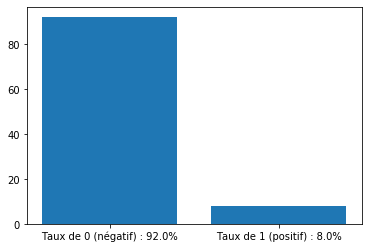

In [8]:
#On affiche la distribution de nos données cible (on observe un déséquilibre)
taux_0 = Counter(y_val)[0]*100/len(y_val)
taux_1 = Counter(y_val)[1]*100/len(y_val)

plt.bar(["Taux de 0 (négatif) : " + str(round(taux_0,1)) + "%"
         ,"Taux de 1 (positif) : " + str(round(taux_1,1))+ "%"]
        , [taux_0,taux_1])

## 4a- XGBoost (mise en place du modèle)

In [9]:
# XGB parameters found by Bayesian optimization
# params = {'n_estimators': 496,
#           'max_depth': 4, 
#           'learning_rate': 0.052819174028842786, 
#           'subsample': 0.8699406829181138,
#           'colsample_bytree': 0.6127121392595005,
#           'random_state': 666}

params = {'n_estimators': 400,
          'max_depth': 5,
          'use_label_encoder': False}

In [10]:
%%time

cls = xgb.XGBClassifier()
# scaler = StandardScaler()
# X_tr_scale = scaler.fit_transform(X_tr)
cls.fit(X_tr, y_tr)

C:\Users\yacin\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:19:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 7min 18s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

## 4b- Performances du modèle XGBoost

In [11]:
 y_pred_xgb = cls.predict_proba(X_val)[:, 1]
[fpr_xgb, tpr_xgb, thr_xgb] = roc_curve(y_val, y_pred_xgb)

C:\Users\yacin\anaconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


In [12]:
auc_xgb = auc(fpr_xgb, tpr_xgb)
print("Accuracy XGBoost : ", auc_xgb)

Accuracy XGBoost :  0.7761077296614688


Text(0, 0.5, 'Sensibilite')

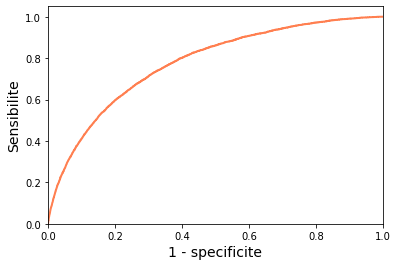

In [13]:
plt.plot(fpr_xgb, tpr_xgb, color='coral', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - specificite', fontsize=14)
plt.ylabel('Sensibilite', fontsize=14)

In [14]:
#On compte les valeurs réelles
print("Valeurs réelles : ", Counter(y_val))

#On fixe un seuil pour les valeurs prédites (0.05 interessant)
seuil = 0.5
y_pred_xgb_0_1 = [0 if x < seuil else 1 for x in y_pred_xgb]
print("Valeurs prédites : ", Counter(y_pred_xgb_0_1))

Valeurs réelles :  Counter({0.0: 56568, 1.0: 4933})
Valeurs prédites :  Counter({0: 60836, 1: 665})


In [15]:
pd.crosstab(y_val, np.array(y_pred_xgb_0_1), rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0.0,56205,363,56568
1.0,4631,302,4933
All,60836,665,61501


- La précision est la probabilité que le test soit positif si la client est un bon client
- La sensibilité est la probabilité que le test soit positif si la client est un mauvais client

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef

print("Accuracy : ", round(accuracy_score(y_val, y_pred_xgb_0_1), 2))
print("Precision : ",round(precision_score(y_val, y_pred_xgb_0_1), 2))
print("Sensibility : ", round(recall_score(y_val, y_pred_xgb_0_1), 2))
print("F1 Score : ",round(f1_score(y_val, y_pred_xgb_0_1), 2))
print("MCC : ",round(matthews_corrcoef(y_val, y_pred_xgb_0_1), 2))


Accuracy :  0.92
Precision :  0.45
Sensibility :  0.06
F1 Score :  0.11
MCC :  0.14


In [17]:
from sklearn.metrics import classification_report

print(classification_report(y_val, y_pred_xgb_0_1))

              precision    recall  f1-score   support

         0.0       0.92      0.99      0.96     56568
         1.0       0.45      0.06      0.11      4933

    accuracy                           0.92     61501
   macro avg       0.69      0.53      0.53     61501
weighted avg       0.89      0.92      0.89     61501



## 5- SMOTE (équilibrage des données)

<BarContainer object of 2 artists>

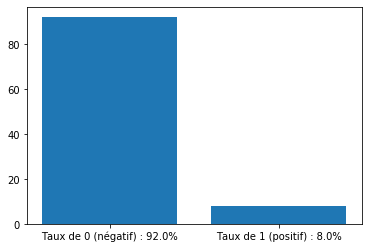

In [18]:
#On affiche la distribution de nos données cible (on observe un déséquilibre)
taux_0 = Counter(y_val)[0]*100/len(y_val)
taux_1 = Counter(y_val)[1]*100/len(y_val)

plt.bar(["Taux de 0 (négatif) : " + str(round(taux_0,1)) + "%"
         ,"Taux de 1 (positif) : " + str(round(taux_1,1))+ "%"]
        , [taux_0,taux_1])

In [19]:
from imblearn.over_sampling import SMOTE

In [20]:
%%time
# Choix de la taille du nouveau dataset 
distribution_of_samples = {0:282680, 1:200000}

# Sur-Echantillonnage en utilisant la méthode SMOTE
smote = SMOTE(sampling_strategy = distribution_of_samples, random_state = 0)
X_over_sample, y_over_sample = smote.fit_resample(X_train, y_train)

Wall time: 58.1 s


In [21]:
Counter(y_over_sample)

Counter({1.0: 200000, 0.0: 282680})

<BarContainer object of 2 artists>

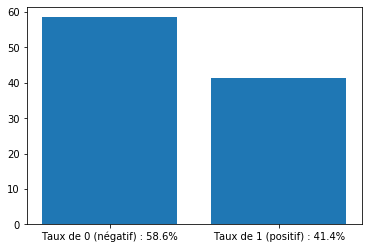

In [22]:
#On affiche la distribution de nos données cible (on observe un déséquilibre)
taux_0 = Counter(y_over_sample)[0]*100/len(y_over_sample)
taux_1 = Counter(y_over_sample)[1]*100/len(y_over_sample)

plt.bar(["Taux de 0 (négatif) : " + str(round(taux_0,1)) + "%"
         ,"Taux de 1 (positif) : " + str(round(taux_1,1))+ "%"]
        , [taux_0,taux_1])

In [23]:
#On effectue un train test pour entrainer et tester notre modèle
X_over_tr, X_over_val, y_over_tr, y_over_val = train_test_split(X_over_sample, y_over_sample, stratify=y_over_sample
                                                                , train_size=0.8, random_state=666)

In [24]:
params = {'n_estimators': 400,
          'max_depth': 5,
          'use_label_encoder': False}

In [25]:
%%time

cls = xgb.XGBClassifier()
# scaler = StandardScaler()
# X_tr_scale = scaler.fit_transform(X_over_tr)
cls.fit(X_over_tr, y_over_tr)

C:\Users\yacin\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:28:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 15min 19s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [26]:
 y_pred_xgb = cls.predict_proba(X_val)[:, 1]
[fpr_xgb, tpr_xgb, thr_xgb] = roc_curve(y_val, y_pred_xgb)

C:\Users\yacin\anaconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


In [27]:
auc_xgb = auc(fpr_xgb, tpr_xgb)
print("Accuracy XGBoost : ", auc_xgb)

Accuracy XGBoost :  0.8501986708873878


Text(0, 0.5, 'Sensibilite')

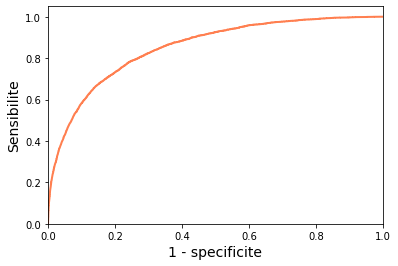

In [28]:
plt.plot(fpr_xgb, tpr_xgb, color='coral', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - specificite', fontsize=14)
plt.ylabel('Sensibilite', fontsize=14)

In [29]:
#On compte les valeurs réelles
print("Valeurs réelles : ", Counter(y_val))

#On fixe un seuil pour les valeurs prédites (0.05 interessant)
seuil = 0.3
y_pred_xgb_0_1 = [0 if x < seuil else 1 for x in y_pred_xgb]
print("Valeurs prédites : ", Counter(y_pred_xgb_0_1))

Valeurs réelles :  Counter({0.0: 56568, 1.0: 4933})
Valeurs prédites :  Counter({0: 58091, 1: 3410})


In [30]:
pd.crosstab(y_val, np.array(y_pred_xgb_0_1), rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0.0,54856,1712,56568
1.0,3235,1698,4933
All,58091,3410,61501


- La précision est la probabilité que le test soit positif si la client est un bon client
- La sensibilité est la probabilité que le test soit positif si la client est un mauvais client

In [31]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef

print("Accuracy : ", round(accuracy_score(y_val, y_pred_xgb_0_1), 2))
print("Precision : ",round(precision_score(y_val, y_pred_xgb_0_1), 2))
print("Sensibility : ", round(recall_score(y_val, y_pred_xgb_0_1), 2))
print("F1 Score : ",round(f1_score(y_val, y_pred_xgb_0_1), 2))
print("MCC : ",round(matthews_corrcoef(y_val, y_pred_xgb_0_1), 2))


Accuracy :  0.92
Precision :  0.5
Sensibility :  0.34
F1 Score :  0.41
MCC :  0.37


## 6- Dashboard interactif

In [32]:
# !pip install streamlit
# !streamlit hello

In [33]:
import streamlit as st

In [34]:
# adding title and text in the app
st.title('Hello World')
st.write("Welcome to your first streamlit application")

2021-08-02 05:43:25.035 
  command:

    streamlit run C:\Users\yacin\anaconda3\lib\site-packages\ipykernel_launcher.py [ARGUMENTS]


In [ ]:
!streamlit run app.py

In [ ]:
y_pred_tr = cls.predict_proba(X_tr)[:, 1]
[fpr_tr, tpr_tr, thr_tr] = roc_curve(y_tr, y_pred_tr)

In [ ]:
print(auc(fpr_tr, tpr_tr))

In [ ]:
plt.plot(fpr_tr, tpr_tr, color='coral', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - specificite', fontsize=14)
plt.ylabel('Sensibilite', fontsize=14)

In [ ]:
#cd Projet\ 6\ -\ Implémentez\ un\ modèle\ de\ scoring\ \(Home\ Credit\)